In [16]:
import copy
import math
import os
from collections import namedtuple
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm


In [17]:
!apt-get install python-box2d
!pip install box2d-py
!pip install gym[Box_2D]
import gym

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-box2d is already the newest version (2.3.2~dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [18]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'lunarlander': gym.make('LunarLander-v2'),
}

In [19]:
#### Exponential Decay

class ExponentialDecay:
    def __init__(self, value_from, value_to, num_steps):

        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = math.log(self.value_to/self.a) / (self.num_steps-1)

    def value(self, step) -> float:

        if step <= 0:
            value = self.value_from
        elif step >= self.num_steps - 1:
            value = self.value_to
        else:
            value = self.a * math.exp(self.b * step)
        
        return value


In [20]:
# Batch namedtuple, a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory as a buffer.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        
        self.idx = 0
 
        self.size = 0

    def add(self, state, action, reward, next_state, done):


        # store the input values into the appropriate attributes, using the current buffer position `self.idx`

        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done
      
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:


        if batch_size >= self.size: 
            sample_indices = torch.arange(self.size)
        else:
            sample_indices = torch.from_numpy(np.random.choice(range(self.size), size=batch_size,replace=False))
        
        sample_indices = sample_indices.long()
        
        states = torch.index_select(self.states, 0, sample_indices)
        actions = torch.index_select(self.actions, 0, sample_indices)
        rewards = torch.index_select(self.rewards, 0, sample_indices)
        next_states = torch.index_select(self.next_states, 0, sample_indices)
        dones = torch.index_select(self.dones, 0, sample_indices)
        
        batch = Batch(states,actions,rewards,next_states,dones)

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.
        """

        # run a random policy for `num_steps` time-steps 

        state = env.reset()
        for i in range(num_steps):
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            self.add(torch.from_numpy(state), action, reward, torch.from_numpy(next_state), done)
            
            state = next_state
            if done:
                state = env.reset()

In [21]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):


        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim


        layer_map = []
        layer_map.append(nn.Linear(self.state_dim,hidden_dim)) # input layer
        layer_map.append(nn.ReLU())

        for i in range(2,num_layers):
            layer_map.append(nn.Linear(self.hidden_dim,self.hidden_dim))
            layer_map.append(nn.ReLU())
            
        layer_map.append(nn.Linear(hidden_dim,self.action_dim)) # output layer
        layer_map.append(nn.Identity())
        
        self.model = nn.Sequential(*layer_map)

    def forward(self, states) -> torch.Tensor:

        return self.model(states)

    
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }



In [22]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.
    """
    # computing the values and target_values tensors using the given models and the batch of data.
    
    # values = current Q values, targets = rewards + gamma * max Q values

    states, actions, rewards, next_states, dones = batch
    length = torch.numel(rewards)
    values = torch.empty(length,dtype=torch.float)
    target_values = np.empty(length)

    for i in range(length):
        values[i] = dqn_model(states[i])[actions[i]]
        if dones[i]:
            target_values[i] = rewards[i]
        else:
            target_values[i] = rewards[i] + gamma * dqn_target(next_states[i])[torch.argmax(dqn_model(states[i])).item()]
            
    target_values = torch.tensor(target_values,dtype=torch.float) # to avoid requires_grad nonsense
            
    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'


    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [34]:
def train_dqn(
    env,
    num_steps,
    *,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    we  train for a given number of time-steps rather than a given number of episodes. 
    """
    # check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []


    i_episode = 0  
    t_episode = 0  
    G = 0 # episode return, 

    state = env.reset()  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    
    pbar = tqdm.notebook.tnrange(num_steps)

    for t_total in pbar:

        #  sampling an action from the DQN using epsilon-greedy
        #  using the action to advance the environment by one step
        #  storing the transition into the replay memory

        eps = exploration.value(t_total)
        
        if np.random.random() < eps:
            action = np.random.randint(env.action_space.n)
        else:
            action = torch.argmax(dqn_model(torch.Tensor(state)))
            action = action.item()
            
        next_state, reward, done, _ = env.step(action)
        G += reward
        
        memory.add(torch.Tensor(state), action, reward, torch.Tensor(next_state), done)
        
        
        #  sampling a batch from the replay memory
        #  performing a batch update 
        
        if t_total % 4 == 0:
            batch = memory.sample(batch_size)
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)

     
        #  updating the target network
        
        if t_total % 10000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # compute return G, store stuff, reset variables, indices and lists
            
            lengths.append(t_episode + 1)
            returns.append(G)
            state = env.reset()

            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            
            G = 0
            i_episode += 1
            t_episode = 0

        else:
      
            
            state = next_state
            t_episode += 1


    return (
        np.array(returns),
        np.array(losses),
    )



#### CartPole 

#### gamma = 0.99
#### num_steps = 1000 # episods 
#### replay_size = 1000
#### replay_prepopulate_steps = 1000
#### batch_size = 64

In [36]:
env = envs['cartpole']

gamma = 0.99
num_steps = 1000 # episods 
replay_size = 1000
replay_prepopulate_steps = 1000
batch_size = 64

exploration = ExponentialDecay(1.0, 0.05, 1000) 

returns,  losses = train_dqn(
    env,
    num_steps,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

  0%|          | 0/1000 [00:00<?, ?it/s]

No handles with labels found to put in legend.


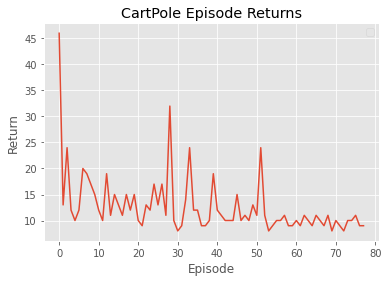

No handles with labels found to put in legend.


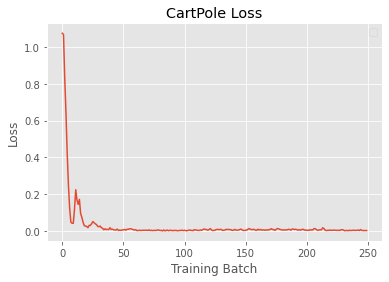

In [37]:
### PLOTTING 
window_size = 1000
plt.plot(returns)
plt.title("CartPole Episode Returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

plt.plot(losses)
plt.title("CartPole Loss")
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()



#### LunarLander

#### gamma = 0.99
#### num_steps = 1000 # episods 
#### replay_size = 1000
#### replay_prepopulate_steps = 1000
#### batch_size = 64


In [32]:
env = envs['lunarlander']

gamma = 0.99
num_steps = 1000
replay_size = 1000
replay_prepopulate_steps = 1000
batch_size = 64

exploration = ExponentialDecay(1.0, 0.05, 1000)


dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

  0%|          | 0/1000 [00:00<?, ?it/s]

No handles with labels found to put in legend.


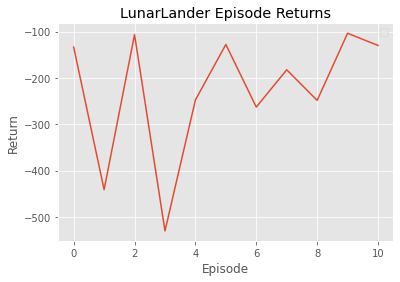

No handles with labels found to put in legend.


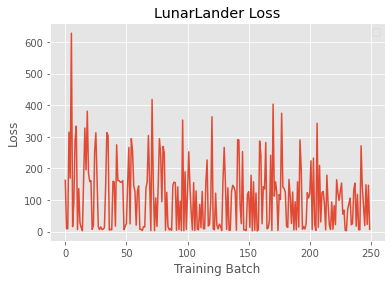

In [33]:
### PLOTTING 
window_size = 1000
plt.plot(returns)
plt.title("LunarLander Episode Returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

plt.plot(losses)
plt.title("LunarLander Loss")
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()
